# Development of a Machine Learning Model for Early Detection of Diabetes

  ## 1.1 Problem Definition
    
**Diabetes** is a chronic disease with significant health complications, including cardiovscular disease, kidney failure, and vision loss. Early     detection is critical for timely intervention and management. Traditional diagnostic methods rely on invasive and time-consuming tests, such as **blood glucose measurements and Hemoglobin A1c test**.

## 1.2 Objective

To design and implement a predictive model that can accurately identify individuals at risk of diabetes using clinical and demographic data.
The goal is: 
- To build learning model that achieves high accuracy, precision and recall.
- Is interpretable and can explain its predictions to clinicians.
- Can be validated in a real-world health care settings.
 

## 1 Problem Definition

### Importing the dependencies

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import itertools
import plotly.graph_objects as go

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score

import pickle
import streamlit as st

import warnings
warnings.simplefilter(action="ignore")

## 2 Data Collection

In [80]:
# loading the datatset to a pandas Dataframe
diabetes_df = pd.read_csv('diabetes.csv')

## 3 Data Exploration and Preparation

### 3.1 Exploratory data Analalaysis(EDA)

#### 3.1.1 Data distribution, relationships, and trends.

In [81]:
diabetes_df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [82]:
diabetes_df.groupby('Outcome').mean()  

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


In [83]:
def check_diabetes_df(dataframe, head=5):
    print("--------Shape------")
    print(dataframe.shape)
    print("--------DataTypes----")
    print(dataframe.dtypes)
    print("--------Head--------")
    print(dataframe.head(head))
    print("------Stastical Description----")
    print(dataframe.describe())
    print("--------Target Count-----")
    print(dataframe['Outcome'].value_counts())
    print("--------Grouping------")
    print(dataframe.groupby('Outcome').mean())
check_diabetes_df(diabetes_df)

--------Shape------
(768, 9)
--------DataTypes----
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
--------Head--------
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.6

##### - Detecting Numerical and Catagorical Value

In [84]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"] 

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car] 

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"] 

    num_cols = [col for col in num_cols if col not in num_but_cat] 
    
    print(f"Observations: {dataframe.shape[0]}") 
    print(f"Variables: {dataframe.shape[1]}") 
    print(f'cat_cols: {len(cat_cols)}') 
    print(f'num_cols: {len(num_cols)}') 
    print(f'cat_but_car: {len(cat_but_car)}') 
    print(f'num_but_cat: {len(num_but_cat)}') 
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [85]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(diabetes_df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [86]:
cat_cols

['Outcome']

In [87]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [88]:
num_but_cat

['Outcome']

#### 3.1.2 Data Visualization

#### A. Analysis For Catagorical data
we find out that we only have one catagorical variable(feature).

         Outcome   Ratio(%)
Outcome                    
0            500  65.104167
1            268  34.895833


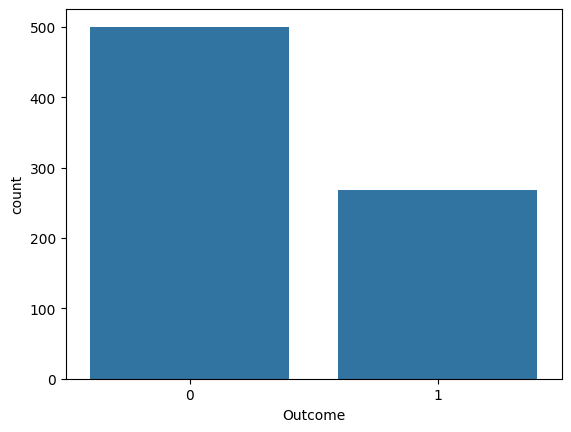

In [89]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio(%)": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
cat_summary(diabetes_df, "Outcome", plot=True)

65% Non-diabetic
35% Diabetic

#### B. Analysis for Numerical data

In [90]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


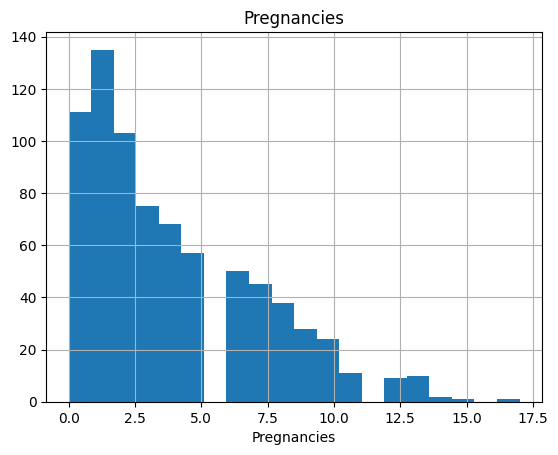

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


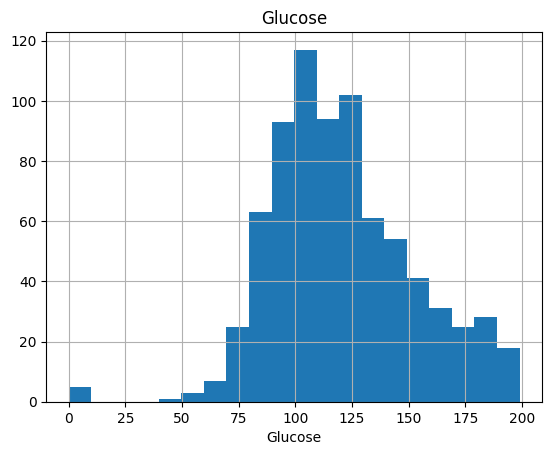

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


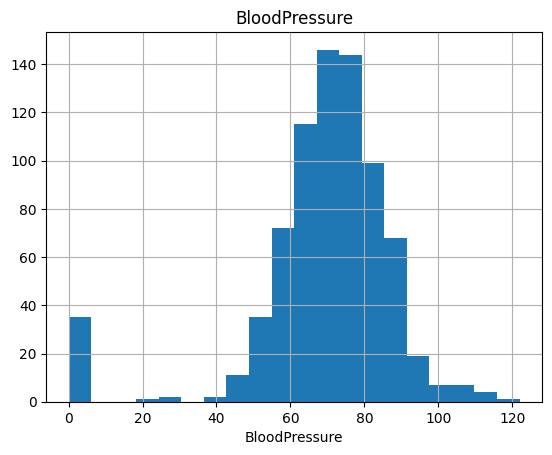

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


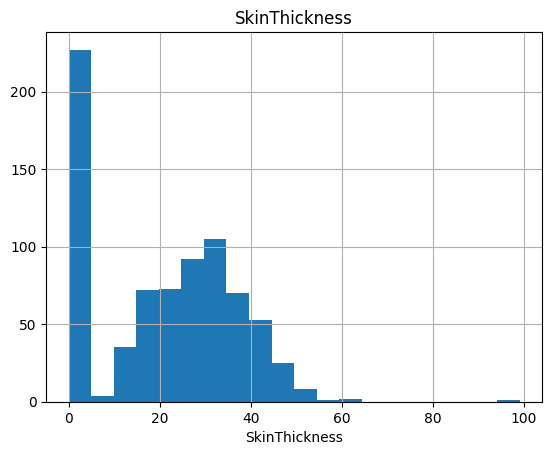

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


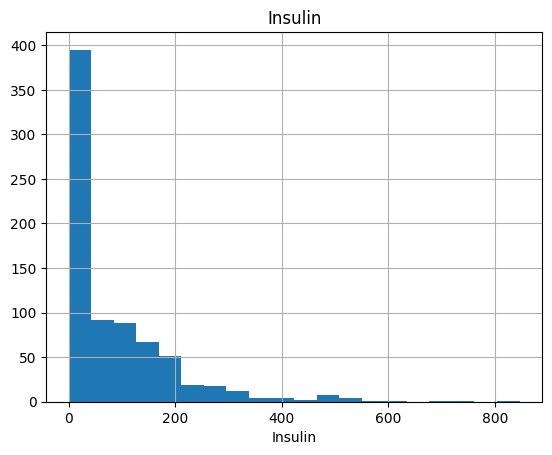

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


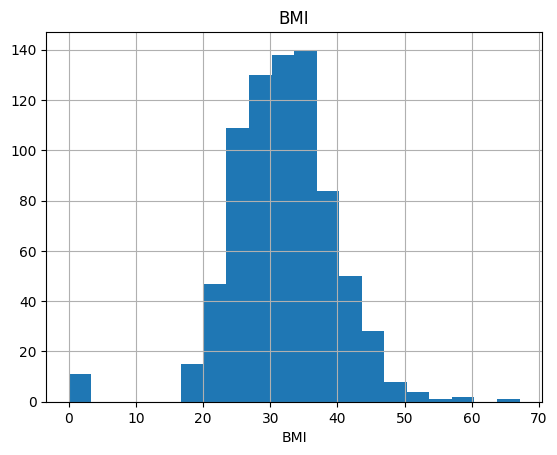

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


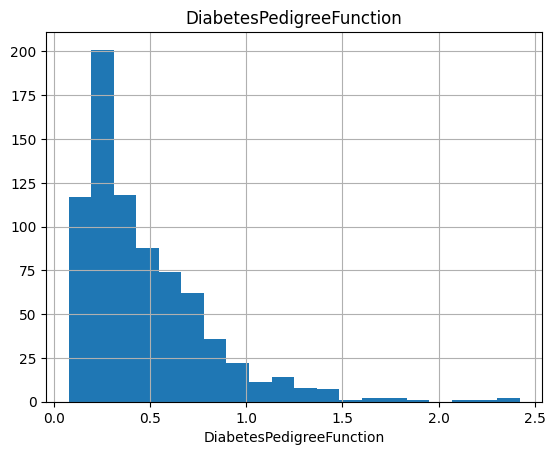

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


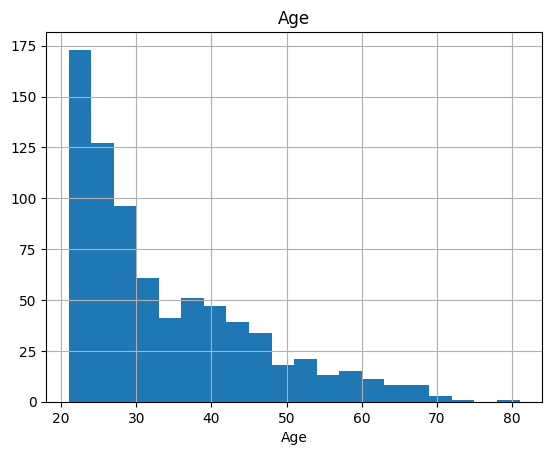

In [91]:
for col in num_cols:
    num_summary(diabetes_df, col, plot=True)

#### Analysis of Numerical value by target

In [92]:
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(pd.DataFrame({numerical_col+'_mean': dataframe.groupby(target)[numerical_col].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=target, y=numerical_col, data=dataframe)
        plt.show(block=True)

         Pregnancies_mean
Outcome                  
0                3.298000
1                4.865672




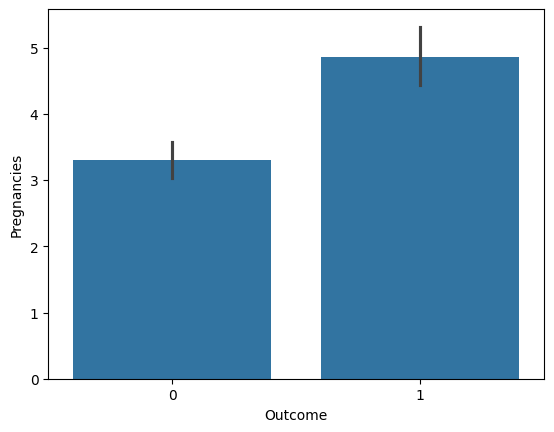

         Glucose_mean
Outcome              
0          109.980000
1          141.257463




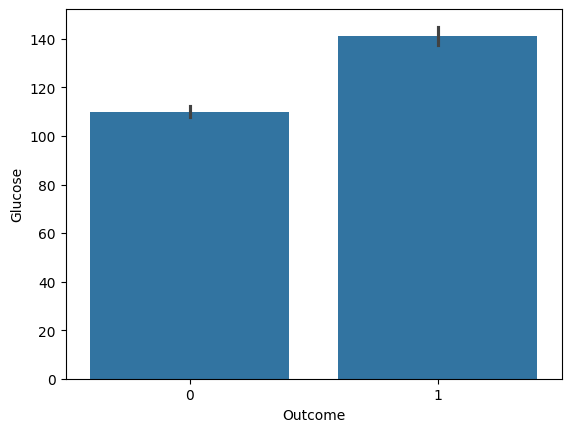

         BloodPressure_mean
Outcome                    
0                 68.184000
1                 70.824627




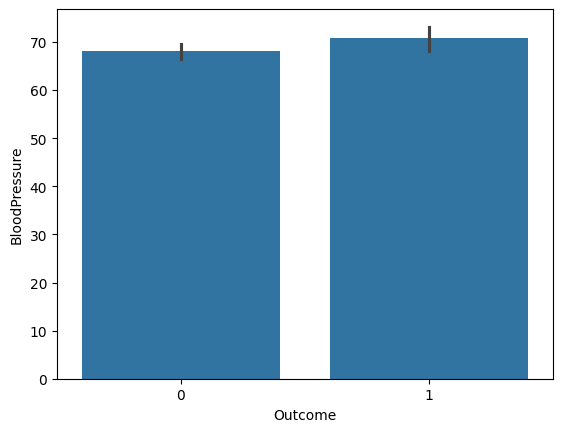

         SkinThickness_mean
Outcome                    
0                 19.664000
1                 22.164179




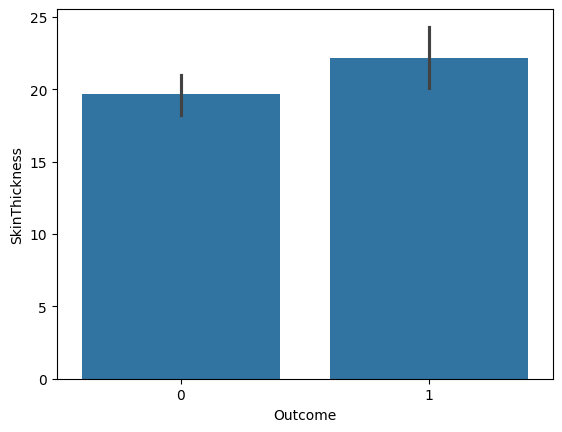

         Insulin_mean
Outcome              
0           68.792000
1          100.335821




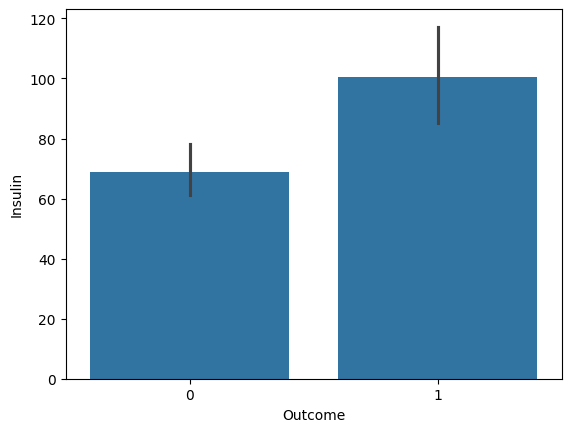

          BMI_mean
Outcome           
0        30.304200
1        35.142537




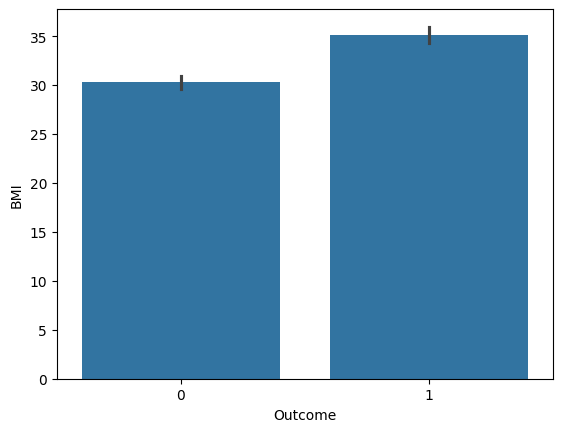

         DiabetesPedigreeFunction_mean
Outcome                               
0                             0.429734
1                             0.550500




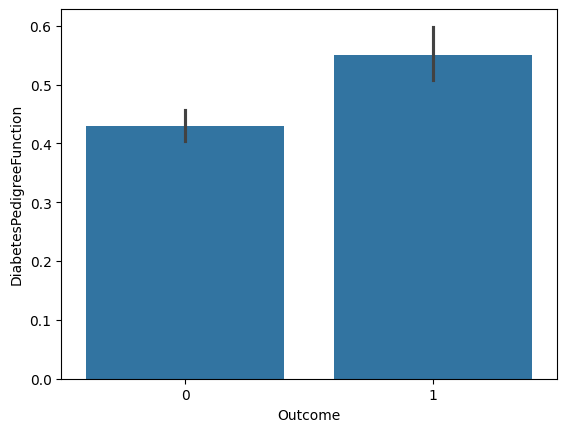

          Age_mean
Outcome           
0        31.190000
1        37.067164




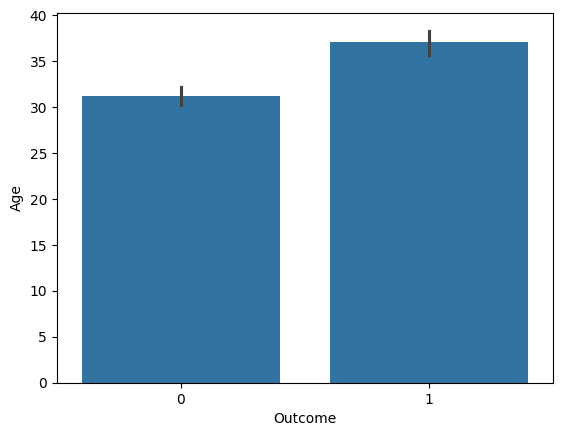

In [93]:
for col in num_cols:
    target_summary_with_num(diabetes_df, "Outcome", col, plot=True)

##### C. Corrlation Analysis

In [94]:
corr = diabetes_df[num_cols].corr()

In [95]:
corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000


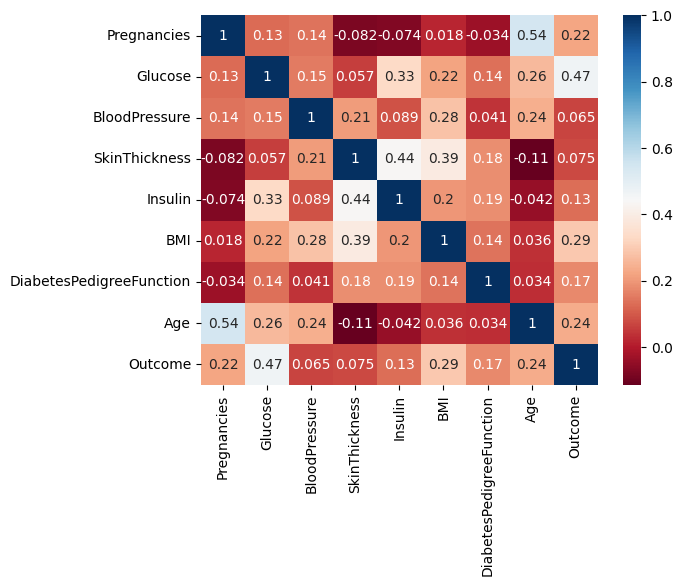

In [96]:
dataplot = sns.heatmap(diabetes_df.corr(numeric_only=True), cmap="RdBu", annot=True)

### 3.2 Data Cleaning

#### A. Missing Value detection and handling

In [97]:
# Detection of variables with missing observations filled with zero in the data set.

zero_columns = [col for col in diabetes_df.columns
                        if (diabetes_df[col].min() == 0 and col not in  ["Pregnancies", "Outcome"])]

In [98]:
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [99]:
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [100]:
# Filling the missing observations in the dataset with NaN that are filled with zero.

for col in zero_columns:
    diabetes_df[col] = np.where(diabetes_df[col] == 0, np.nan, diabetes_df[col])

In [101]:
diabetes_df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [102]:
def missing_values_table(dataframe, na_name=False, plot=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if plot:
        # Plotting the missing values
        plt.figure(figsize=(10, 8))
        bars = plt.bar(missing_df.index, missing_df['ratio'], color='purple')
        plt.xlabel('Features')
        plt.ylabel('Percentage of Missing Values')
        plt.title('Missing Values by Feature')
        
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', ha='center', va='bottom')
        
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    
    if na_name:
        return na_columns

               n_miss  ratio
Insulin           374  48.70
SkinThickness     227  29.56
BloodPressure      35   4.56
BMI                11   1.43
Glucose             5   0.65


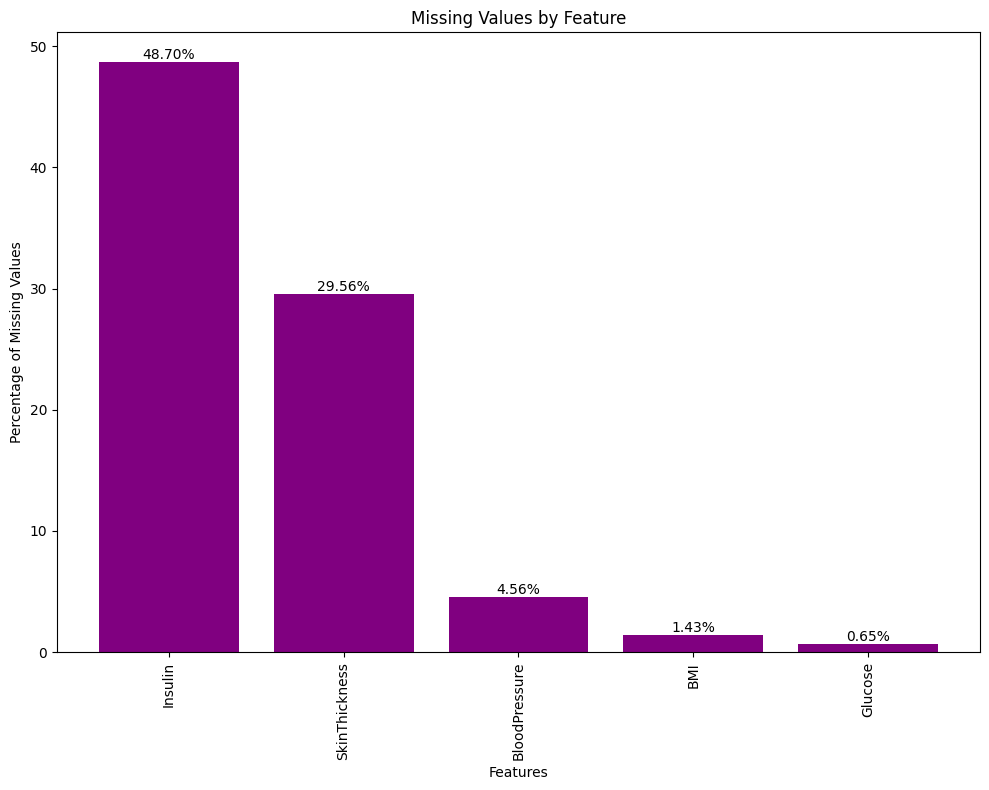

In [103]:
na_columns = missing_values_table(diabetes_df, na_name=True, plot=True)

In [104]:
dff = diabetes_df[na_columns]

In [105]:
rs = RobustScaler()

In [106]:
dff = pd.DataFrame(rs.fit_transform(dff), columns=dff.columns)

In [107]:
dff.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,0.738095,0.000,0.428571,NaN,0.142857
1,-0.761905,-0.375,0.000000,NaN,-0.626374
2,1.571429,-0.500,NaN,NaN,-0.989011
3,-0.666667,-0.375,-0.428571,-0.272527,-0.461538
4,0.476190,-2.000,0.428571,0.378022,1.186813


In [108]:
# Filing the missing observations using knn imputers
dff = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(dff), columns = dff.columns)

In [109]:
dff.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,0.738095,0.000,0.428571,0.624176,0.142857
1,-0.761905,-0.375,0.000000,-0.451868,-0.626374
2,1.571429,-0.500,-0.242857,0.819341,-0.989011
3,-0.666667,-0.375,-0.428571,-0.272527,-0.461538
4,0.476190,-2.000,0.428571,0.378022,1.186813


In [110]:
dff = pd.DataFrame(rs.inverse_transform(dff), columns=dff.columns)

In [111]:
dff.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,148.0,72.0,35.0,196.0,33.6
1,85.0,66.0,29.0,73.6,26.6
2,183.0,64.0,25.6,218.2,23.3
3,89.0,66.0,23.0,94.0,28.1
4,137.0,40.0,35.0,168.0,43.1


In [112]:
diabetes_df[na_columns] = dff

In [113]:
diabetes_df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,196.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,73.6,26.6,0.351,31,0
2,8,183.0,64.0,25.6,218.2,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
5,5,116.0,74.0,24.2,85.0,25.6,0.201,30,0
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
7,10,115.0,69.4,36.6,123.2,35.3,0.134,29,0
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
9,8,125.0,96.0,40.2,163.6,31.1,0.232,54,1


In [114]:
# checking missing values after filling them using knn imputation
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### B. Outlier Analysis

In [115]:
# setting the outlier threshold using the tukey method 
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [116]:
# checking outlier
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [117]:
# checking outlier using boxplot
def check_outlier(dataframe, col_name, plot=False):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    outliers = dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)]
    if outliers.any(axis=None):
        if plot:
            plt.figure(figsize=(8, 6))
            sns.boxplot(x=dataframe[col_name])
            plt.title(f'Outliers in {col_name}')
            plt.show()
        return True
    else:
        return False

In [118]:
# replacing with threshold 
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

Pregnancies False
Glucose False
BloodPressure False


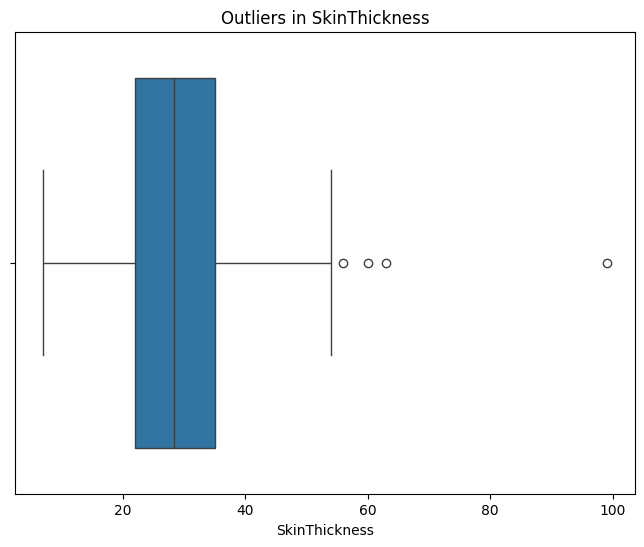

SkinThickness True


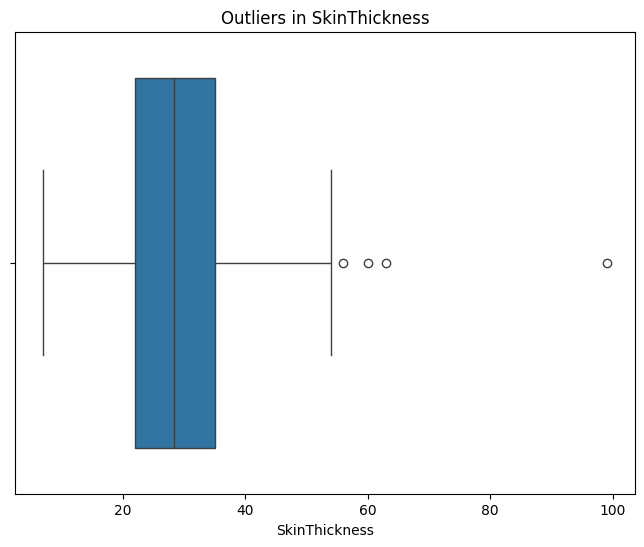

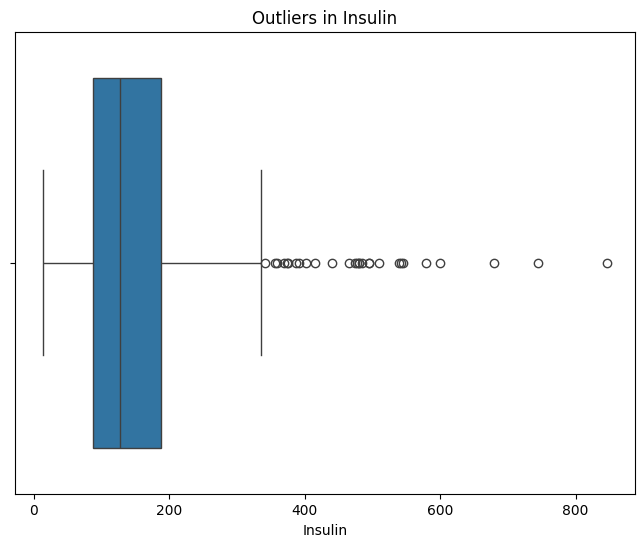

Insulin True


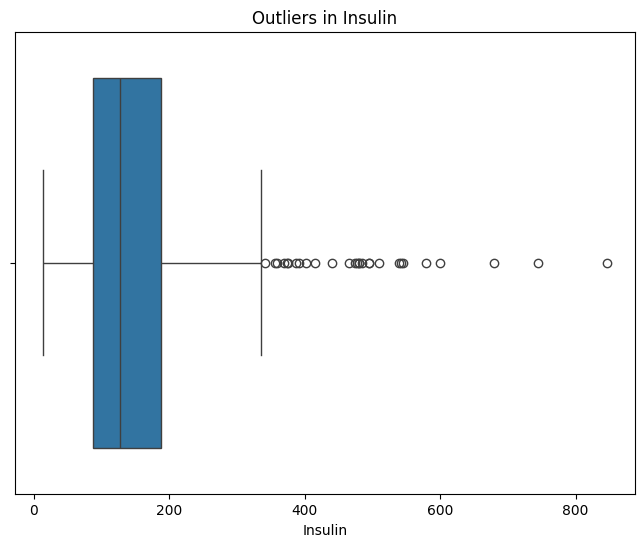

BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [119]:
# results for the above functions
for col in diabetes_df.columns:
    print(col, check_outlier(diabetes_df, col, plot=True))
    if check_outlier(diabetes_df, col, plot=True):
        replace_with_thresholds(diabetes_df, col)

In [120]:
for col in diabetes_df.columns:
    print(col, check_outlier(diabetes_df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


**No outlier is visible here.**

### 3.3 Feature Engineering

#### Feature Extraction

In [121]:
# Converting BMI to catagorical value below 18.5 is underweight, between 18.5 and 24.9 is normal, between 24.9 and 29.9 is overweight and above 30 is obese

diabetes_df['NEW_BMI'] = pd.cut(x=diabetes_df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])

In [122]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_BMI
0,6,148.0,72.0,35.0,196.0,33.6,0.627,50,1,Obese
1,1,85.0,66.0,29.0,73.6,26.6,0.351,31,0,Overweight
2,8,183.0,64.0,25.6,218.2,23.3,0.672,32,1,Healthy
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obese


In [123]:
# Converting Glucose Value to Categorical feature

diabetes_df["NEW_GLUCOSE"] = pd.cut(x=diabetes_df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

In [124]:
# Deriving a Categorical feature with Insulin Value.

def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return
    else:
        return "Abnormal"

diabetes_df["NEW_INSULIN_SCORE"] = diabetes_df.apply(set_insulin, axis=1)
diabetes_df["NEW_GLUCOSE * INSULIN"] =diabetes_df["Glucose"] * diabetes_df["Insulin"]

In [125]:
# Translating Column Names to Uppercase Letters.

diabetes_df.columns = [col.upper() for col in diabetes_df.columns]

In [154]:
diabetes_df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE,NEW_INSULIN_SCORE,NEW_GLUCOSE * INSULIN,NEW_BMI_Healthy,NEW_BMI_Obese,NEW_BMI_Overweight,NEW_BMI_Underweight
0,0.6,0.765432,0.000,0.515385,0.680299,0.159341,0.665359,1.235294,1,0.0,1,0.846881,0.0,1.0,0.0,0.0
1,-0.4,-0.790123,-0.375,0.053846,-0.540648,-0.609890,-0.056209,0.117647,0,1.0,0,-0.534959,0.0,0.0,1.0,0.0
2,1.0,1.629630,-0.500,-0.207692,0.901746,-0.972527,0.783007,0.176471,1,0.0,1,1.510264,1.0,0.0,0.0,0.0
3,-0.4,-0.691358,-0.375,-0.407692,-0.337157,-0.445055,-0.537255,-0.470588,0,1.0,0,-0.406808,0.0,0.0,1.0,0.0
4,-0.6,0.493827,-2.000,0.515385,0.400998,1.203297,5.007843,0.235294,1,1.0,1,0.482958,0.0,1.0,0.0,0.0


In [127]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [128]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(diabetes_df)

Observations: 768
Variables: 13
cat_cols: 4
num_cols: 9
cat_but_car: 0
num_but_cat: 3


In [129]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'NEW_GLUCOSE * INSULIN']

In [130]:
cat_cols

['NEW_INSULIN_SCORE', 'OUTCOME', 'NEW_BMI', 'NEW_GLUCOSE']

In [131]:
diabetes_df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_BMI,NEW_GLUCOSE,NEW_INSULIN_SCORE,NEW_GLUCOSE * INSULIN
0,6,148.0,72.0,35.0,196.0,33.6,0.627,50,1,Obese,Prediabetes,Abnormal,29008.0
1,1,85.0,66.0,29.0,73.6,26.6,0.351,31,0,Overweight,Normal,None,6256.0
2,8,183.0,64.0,25.6,218.2,23.3,0.672,32,1,Healthy,Prediabetes,Abnormal,39930.6
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight,Normal,None,8366.0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obese,Normal,Abnormal,23016.0


#### Feature Encoding

In [132]:
cat_cols = [col for col in cat_cols if col not in ["OUTCOME"]]

In [133]:
cat_cols

['NEW_INSULIN_SCORE', 'NEW_BMI', 'NEW_GLUCOSE']

In [134]:
diabetes_df['NEW_GLUCOSE'] = diabetes_df['NEW_GLUCOSE'].apply(
    lambda x: 1 if x == 'Normal' else (0 if x == 'Prediabetes' else None))
diabetes_df['NEW_INSULIN_SCORE'] = diabetes_df['NEW_INSULIN_SCORE'].apply(
    lambda x: 1 if x == 'Abnormal' else (0 if x == None else None))

In [135]:
diabetes_df.dtypes

PREGNANCIES                    int64
GLUCOSE                      float64
BLOODPRESSURE                float64
SKINTHICKNESS                float64
INSULIN                      float64
BMI                          float64
DIABETESPEDIGREEFUNCTION     float64
AGE                            int64
OUTCOME                        int64
NEW_BMI                     category
NEW_GLUCOSE                  float64
NEW_INSULIN_SCORE              int64
NEW_GLUCOSE * INSULIN        float64
dtype: object

In [136]:
#Extract categorical columns from the dataframe
#Here we extract the columns with category datatype as they are the categorical columns

cat_cols = diabetes_df.select_dtypes(include=['category']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)

In [137]:
# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(diabetes_df[cat_cols])

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(cat_cols))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([diabetes_df, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(cat_cols, axis=1)

In [138]:
diabetes_df = df_encoded

In [139]:
cat_cols

['NEW_BMI']

In [140]:
diabetes_df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE,NEW_INSULIN_SCORE,NEW_GLUCOSE * INSULIN,NEW_BMI_Healthy,NEW_BMI_Obese,NEW_BMI_Overweight,NEW_BMI_Underweight
0,6,148.0,72.0,35.0,196.0,33.6,0.627,50,1,0.0,1,29008.0,0.0,1.0,0.0,0.0
1,1,85.0,66.0,29.0,73.6,26.6,0.351,31,0,1.0,0,6256.0,0.0,0.0,1.0,0.0
2,8,183.0,64.0,25.6,218.2,23.3,0.672,32,1,0.0,1,39930.6,1.0,0.0,0.0,0.0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,1.0,0,8366.0,0.0,0.0,1.0,0.0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,1.0,1,23016.0,0.0,1.0,0.0,0.0


#### Feature Standardizar

In [141]:
scaler = RobustScaler()

In [142]:
diabetes_df[num_cols] = scaler.fit_transform(diabetes_df[num_cols])

In [143]:
cat_cols

['NEW_BMI']

In [144]:
diabetes_df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE,NEW_INSULIN_SCORE,NEW_GLUCOSE * INSULIN,NEW_BMI_Healthy,NEW_BMI_Obese,NEW_BMI_Overweight,NEW_BMI_Underweight
0,0.6,0.765432,0.000,0.515385,0.680299,0.159341,0.665359,1.235294,1,0.0,1,0.846881,0.0,1.0,0.0,0.0
1,-0.4,-0.790123,-0.375,0.053846,-0.540648,-0.609890,-0.056209,0.117647,0,1.0,0,-0.534959,0.0,0.0,1.0,0.0
2,1.0,1.629630,-0.500,-0.207692,0.901746,-0.972527,0.783007,0.176471,1,0.0,1,1.510264,1.0,0.0,0.0,0.0
3,-0.4,-0.691358,-0.375,-0.407692,-0.337157,-0.445055,-0.537255,-0.470588,0,1.0,0,-0.406808,0.0,0.0,1.0,0.0
4,-0.6,0.493827,-2.000,0.515385,0.400998,1.203297,5.007843,0.235294,1,1.0,1,0.482958,0.0,1.0,0.0,0.0


In [145]:
diabetes_df.shape

(768, 16)

### 3.4 Data Spliting

In [146]:
# Creating the Dependent Variable.

y = diabetes_df["OUTCOME"]

# Creating Independent Variables.

X = diabetes_df.drop("OUTCOME", axis=1)

# Splitting the Data into Training and Test Sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)


In [147]:
X_train

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_GLUCOSE,NEW_INSULIN_SCORE,NEW_GLUCOSE * INSULIN,NEW_BMI_Healthy,NEW_BMI_Obese,NEW_BMI_Overweight,NEW_BMI_Underweight
600,-0.4,-0.222222,1.000,-0.715385,-0.235411,-0.554945,0.071895,-0.294118,1.0,0,-0.231430,0.0,0.0,1.0,0.0
248,1.2,0.172840,-0.125,0.361538,2.735162,0.357143,-0.236601,0.294118,1.0,1,2.112596,0.0,1.0,0.0,0.0
582,1.8,0.098765,0.375,-0.869231,-0.235411,-0.620879,-0.296732,1.941176,1.0,0,-0.149159,0.0,0.0,1.0,0.0
274,2.0,-0.271605,-0.125,0.176923,-0.125686,0.225275,-0.317647,1.352941,1.0,0,-0.173271,0.0,1.0,0.0,0.0
518,2.0,-1.012346,-0.750,-0.146154,-0.672319,0.071429,-0.503268,0.705882,1.0,0,-0.636119,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.2,-0.049383,0.000,-0.407692,-0.496758,-0.357143,0.009150,1.000000,1.0,0,-0.370125,0.0,0.0,1.0,0.0
390,-0.4,-0.419753,-0.375,0.053846,0.680299,-0.016484,0.186928,0.764706,1.0,1,0.275487,0.0,1.0,0.0,0.0
143,1.4,-0.222222,-0.375,0.223077,-0.227431,0.027473,-0.262745,0.764706,1.0,0,-0.226183,0.0,1.0,0.0,0.0
241,0.2,-0.641975,-0.125,0.284615,-0.397007,0.104396,0.192157,-0.411765,1.0,0,-0.428551,0.0,1.0,0.0,0.0


## 4. Model Selection and Development

### 4.1 Model Selection

Our objective is to build a high acurracy precision and recall model thatis interpretable by clincians and be valated easily by real-world health care settings. Thus, I used **Logistic regression** model as it is easy to implement and interpret with less computational cost.

### 4.2 Model development

#### Design and Create model

#### Train the model

In [148]:
lr_model = LogisticRegression(random_state=46).fit(X_train, y_train)

### 4.2 Test, Evaluation and Hyperparameter Tuning

#### Test and Evaluation

In [149]:
lr_pred = lr_model.predict(X_test)

print("Logistic Regression:")
print(f"Accuracy: {round(accuracy_score(lr_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(lr_pred, y_test), 4)}")
print(f"Precision: {round(precision_score(lr_pred, y_test), 4)}")
print(f"F1: {round(f1_score(lr_pred, y_test), 4)}")
print(f"AUC: {round(roc_auc_score(lr_pred, y_test), 4)}")

Logistic Regression:
Accuracy: 0.7446
Recall: 0.6774
Precision: 0.5185
F1: 0.5874
AUC: 0.7233


#### Hyperparameter tuning and Evaluation

In [150]:
lr_model = LogisticRegression(random_state=46)
parameters = {'C': [0.1, 1, 10],
              'penalty': ['l1', 'l2']}
lr_grid = GridSearchCV(lr_model, parameters, cv=5).fit(X_train, y_train)

best_lr_model = lr_grid.best_estimator_

print("Logistic Regression - Hyperparameter Optimization")
print(f"Best Parameters: {lr_grid.best_params_}")
print(f"Accuracy: {round(lr_grid.best_score_, 4)}")
print(f"Recall: {round(recall_score(best_lr_model.predict(X_test), y_test), 4)}")
print(f"Precision: {round(precision_score(best_lr_model.predict(X_test), y_test), 4)}")
print(f"F1: {round(f1_score(best_lr_model.predict(X_test), y_test), 4)}")
print(f"AUC: {round(roc_auc_score(best_lr_model.predict(X_test), y_test), 4)}")

Logistic Regression - Hyperparameter Optimization
Best Parameters: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.7655
Recall: 0.6818
Precision: 0.5556
F1: 0.6122
AUC: 0.7318


In [151]:
diabetes_prediction = best_lr_model.predict(X_test)

In [153]:
X_test

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_GLUCOSE,NEW_INSULIN_SCORE,NEW_GLUCOSE * INSULIN,NEW_BMI_Healthy,NEW_BMI_Obese,NEW_BMI_Overweight,NEW_BMI_Underweight
649,-0.6,-0.246914,-0.7500,-0.253846,-0.083791,-0.631868,-0.626144,-0.352941,1.0,0,-0.138980,0.0,0.0,1.0,0.0
516,1.2,0.691358,1.0000,0.438462,0.371072,-0.203297,1.041830,1.411765,0.0,0,0.538166,0.0,1.0,0.0,0.0
151,0.2,-0.074074,-0.4375,-0.823077,-0.379052,-1.126374,0.155556,0.470588,1.0,0,-0.293161,1.0,0.0,0.0,0.0
381,-0.6,-0.296296,-0.2500,-0.484615,-0.586534,-1.335165,-0.356863,-0.411765,1.0,0,-0.474892,1.0,0.0,0.0,0.0
325,-0.4,0.987654,0.0000,-0.561538,0.400998,-0.719780,-0.652288,-0.294118,0.0,1,0.687027,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,-0.6,0.493827,-0.1250,0.746154,0.770075,0.115385,-0.529412,-0.411765,1.0,1,0.790823,0.0,1.0,0.0,0.0
520,-0.2,-1.209877,-0.1250,0.284615,-0.616459,-0.785714,-0.484967,-0.235294,1.0,0,-0.642338,0.0,0.0,1.0,0.0
14,0.4,1.209877,0.0000,-0.715385,0.470823,-0.697802,0.560784,1.294118,0.0,1,0.849432,0.0,0.0,1.0,0.0
202,-0.6,-0.222222,-0.2500,-0.638462,-0.444888,-0.532967,1.083660,0.176471,1.0,0,-0.369177,0.0,0.0,1.0,0.0


## 5. Deployment